# Exercise 02: Multi-class Classification 
In this exercise, you will train a deep model on the CIFAR10-LT from the scratch using PyTorch. The following tasks should be done:
- Task 1: per batch training/testing
- Task 2: Plotting Loss and Accuracy
- Task 3: Instance inference and visualization

### Basic Imports

In [11]:
import os
import time
import os.path as osp

import numpy as np
import pandas as pd

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader

from torchvision import datasets
from torchvision import transforms
import torchvision

import matplotlib.pyplot as plt
from PIL import Image

from imbalance_data.cifar10Imbanlance import Cifar10Imbanlance # dataloader
from models.simplenet import SimpleNet # model

### Hyperparameters

In [12]:
# random seed
SEED = 1 

# Dataset
IMBALANCE_RATIO = 0.1
DATASET_DIR = "/shareddata/"
# DATASET_DIR = "./data"
NUM_CLASS = 10

# Training
BATCH_SIZE = 128
NUM_EPOCHS = 30
EVAL_INTERVAL=1
SAVE_DIR = './log'

# Optimizer
LEARNING_RATE = 1e-1
MOMENTUM = 0.9
STEP=5
GAMMA=0.5


### Device

In [13]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


### Dataset


In [14]:
imbanlance_rate = IMBALANCE_RATIO
root = DATASET_DIR

# cifar10 transform
transform_cifar10_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

transform_cifar10_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])


trainset = Cifar10Imbanlance(imbanlance_rate, transform=transform_cifar10_train, train=True, file_path=root)
testset = Cifar10Imbanlance(imbanlance_rate, transform=transform_cifar10_test, train=False, file_path=root)


train_dataloader = torch.utils.data.DataLoader(trainset, batch_size=BATCH_SIZE, shuffle=True)
test_dataloader = torch.utils.data.DataLoader(testset, batch_size=BATCH_SIZE, shuffle=False)




d=dict()
for train_data,train_label in train_dataloader:
    for labels in train_label:
        label=labels.item()
        if label in d.keys():
            d[label]+=1
        else:
            d[label]=1

num = max(d.keys()) + 1
class_counts = torch.zeros(num, dtype=torch.int64)
for label, count in d.items():
    class_counts[label] = count 

class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

for i, count in enumerate(class_counts):
    print(f"{class_names[i]}: {int(count)} samples")

Files already downloaded and verified
Files already downloaded and verified
airplane: 5000 samples
automobile: 3871 samples
bird: 2997 samples
cat: 2320 samples
deer: 1796 samples
dog: 1391 samples
frog: 1077 samples
horse: 834 samples
ship: 645 samples
truck: 500 samples


### Model

In [15]:
model = SimpleNet()
model = model.cuda()

### Optimizer

In [16]:
optimizer = optim.SGD(model.parameters(), lr=LEARNING_RATE, momentum=MOMENTUM)

scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=STEP, gamma=GAMMA)

### Task 1: per batch training/testing
---

Please denfine two function named ``train_batch`` and ``test_batch``. These functions are essential for training and evaluating machine learning models using batched data from dataloaders.

**To do**: 
1. Define the loss function i.e *nn.CrossEntropyLoss()*.
2. Take the image as the input and generate the output using the pre-defined SimpleNet.
3. Calculate the loss between the output and the corresponding label using the loss function.

In [17]:
##################### Write your answer here ##################
# Define the loss function

###############################################################

def train_batch(model, image, target):
    """
    Perform one training batch iteration.

    Args:
        model (torch.nn.Module): The machine learning model to train.
        image (torch.Tensor): Batch of input data (images).
        target (torch.Tensor): Batch of target labels.

    Returns:
        torch.Tensor: Model output (predictions) for the batch.
        torch.Tensor: Loss value calculated for the batch.
    """
    
    ##################### Write your answer here ##################

    ###############################################################

    return output, loss


def test_batch(model, image, target):
    """
    Perform one testing batch iteration.

    Args:
        model (torch.nn.Module): The machine learning model to evaluate.
        image (torch.Tensor): Batch of input data (images).
        target (torch.Tensor): Batch of target labels.

    Returns:
        torch.Tensor: Model output (predictions) for the batch.
        torch.Tensor: Loss value calculated for the batch.
    """

    ##################### Write your answer here ##################
    output = model(image)
    loss = criterion(output, target)
    ###############################################################

    return output, loss

### Model Training

In [18]:
training_loss = []
training_acc = []
testing_loss = []
testing_acc = []

for epoch in range(NUM_EPOCHS):
    model.train()
    torch.cuda.empty_cache()

    ##########################
    ### Training
    ##########################

    running_cls_loss = 0.0
    running_cls_corrects = 0

    for batch_idx, (image, target) in enumerate(train_dataloader):

        image = image.to(device)
        target = target.to(device)

        # train model
        outputs, loss = train_batch(model, image, target)
        _, preds = torch.max(outputs, 1)

        
        loss_data = loss.data.item()
        if np.isnan(loss_data):
            raise ValueError('loss is nan while training')
        running_cls_loss += loss.item()
        running_cls_corrects += torch.sum(preds == target.data)

        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

    epoch_loss = running_cls_loss / len(trainset)
    epoch_acc = running_cls_corrects.double() / len(trainset)

    print(f'Epoch: {epoch+1}/{NUM_EPOCHS} Train Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

    training_loss.append(epoch_loss)
    training_acc.append(epoch_acc.cpu().detach().numpy())

    # change learning rate
    scheduler.step()


    ##########################
    ### Testing
    ##########################
    # # eval model during training or in the last epoch
    if (epoch + 1) % EVAL_INTERVAL == 0 or (epoch +1) == NUM_EPOCHS:
        print('Begin test......')
        model.eval()

        val_loss = 0.0
        val_corrects = 0

        for batch_idx, (image, target) in enumerate(test_dataloader):

            image = image.to(device)
            target = target.to(device)

            # test model
            outputs, loss = test_batch(model, image, target)
            _, preds = torch.max(outputs, 1)
            
            val_loss += loss.item()
            val_corrects += torch.sum(preds == target.data)

        val_loss = val_loss / len(testset)
        val_acc = val_corrects.double() / len(testset)
        print(f'Test Loss: {val_loss:.4f} Acc: {val_acc:.4f}')
        testing_loss.append(val_loss)
        testing_acc.append(val_acc.cpu().detach().numpy())

        # save the model in last epoch
        if (epoch +1) == NUM_EPOCHS:
            
            state = {
            'state_dict': model.state_dict(),
            'acc': epoch_acc,
            'epoch': (epoch+1),
            }

            # check the dir
            if not os.path.exists(SAVE_DIR):
                os.makedirs(SAVE_DIR)

            # save the state
            torch.save(state, osp.join(SAVE_DIR, 'checkpoint_%s.pth' % (str(epoch+1))))



Epoch: 1/30 Train Loss: 0.0142 Acc: 0.3391
Begin test......
Test Loss: 0.0171 Acc: 0.2319
Epoch: 2/30 Train Loss: 0.0129 Acc: 0.4166
Begin test......
Test Loss: 0.0160 Acc: 0.2856
Epoch: 3/30 Train Loss: 0.0123 Acc: 0.4420
Begin test......
Test Loss: 0.0157 Acc: 0.2953
Epoch: 4/30 Train Loss: 0.0121 Acc: 0.4558
Begin test......
Test Loss: 0.0155 Acc: 0.3247
Epoch: 5/30 Train Loss: 0.0122 Acc: 0.4470
Begin test......
Test Loss: 0.0153 Acc: 0.2891
Epoch: 6/30 Train Loss: 0.0115 Acc: 0.4781
Begin test......
Test Loss: 0.0144 Acc: 0.3463
Epoch: 7/30 Train Loss: 0.0112 Acc: 0.4954
Begin test......
Test Loss: 0.0143 Acc: 0.3531
Epoch: 8/30 Train Loss: 0.0112 Acc: 0.4930
Begin test......
Test Loss: 0.0148 Acc: 0.3557
Epoch: 9/30 Train Loss: 0.0112 Acc: 0.4971
Begin test......
Test Loss: 0.0151 Acc: 0.3643
Epoch: 10/30 Train Loss: 0.0111 Acc: 0.5021
Begin test......
Test Loss: 0.0146 Acc: 0.3473
Epoch: 11/30 Train Loss: 0.0107 Acc: 0.5175
Begin test......
Test Loss: 0.0145 Acc: 0.3478
Epoch: 1

### Task 2: Plotting Loss and Accuracy
---
The task is to create a function named ``plot_loss_and_accuracy`` that generates a visualization showing the training and testing loss as well as training and testing accuracy over different epochs during the training of a machine learning model.

**To do**: 
1. Plot the training and testing loss curves on the left subplot.
2. Plot the training and testing accuracy curves on the right subplot.

In [19]:


def plot_loss_and_accuracy(training_loss, training_acc, testing_loss, testing_acc):
    """
    Plot training and testing loss, as well as training and testing accuracy.

    Args:
        training_loss (list or array): Training loss values over epochs.
        training_acc (list or array): Training accuracy values over epochs.
        testing_loss (list or array): Testing loss values over epochs.
        testing_acc (list or array): Testing accuracy values over epochs.
    """

    plt.figure(figsize=(10, 4))

     # Plot the training and testing loss curves in the left subplot
    plt.subplot(1, 2, 1)  # loss subplot

    ##################### Write your answer here ##################

    ###############################################################
    
    plt.title("Loss over Epochs")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()

    # Plot the training and testing accuracy curves in the right subplot
    plt.subplot(1, 2, 2)  # accuracy subplot

    ##################### Write your answer here ##################

    ###############################################################

    plt.title("Accuracy over Epochs")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend()

    plt.tight_layout()
    plt.show()



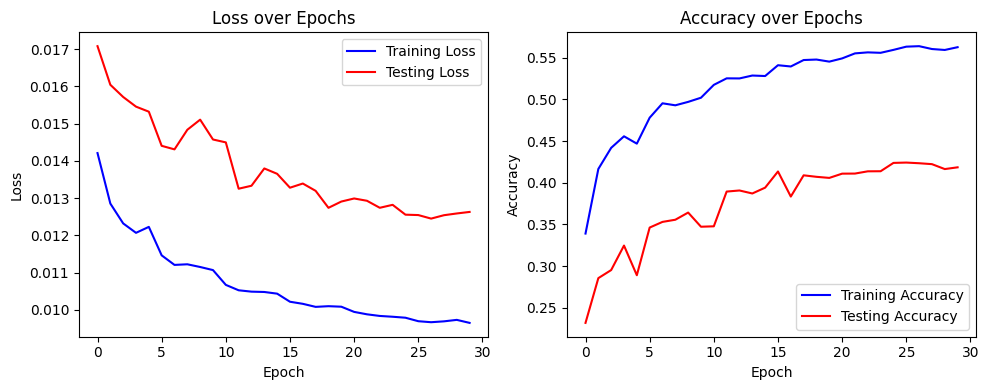

In [20]:
plot_loss_and_accuracy(training_loss, training_acc, testing_loss, testing_acc)
# print(training_acc)

### Task 3: Instance inference and visualization
---
The task is to create a function named ``instance_inference`` that visualizes an image along with model predictions and class probabilities. Note that this function assumes that you have a pre-trained model and you are passing the model's output tensor as outputs. The function then extracts predictions and probabilities from this output tensor.
**To do**: 
1. Calculate the prediction and the probabilities for each class.
         

In [21]:
def instance_inference(inputs, outputs, class_names, title=None):
    """
    Display image for Tensor with model outputs and class probabilities.
    Args:
        inputs (CxHxW Tensor): Input image tensor.
        outputs (1xK Tensor): Model's output tensor.
        class_names (list): List of class names.
        title (str, optional): Title for the image. Default is None.
    """
    images = inputs.cpu().numpy().transpose((1, 2, 0))

    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    images = std * images + mean
    
    images = np.clip(images, 0, 1)
    plt.imshow(images)

    if title is not None:
        plt.title(title)

    ##################### Write your answer here ##################
    # two outputs:
    # 1. predict_index
    # 2. probabilities

    ###############################################################


    predicted_class = class_names[predict_index.item()]
    predicted_probability = probabilities[predict_index].item()

    plt.text(17, 30, f'Predicted Class: {predicted_class}\nProbability: {predicted_probability:.2f}', 
             color='white', backgroundcolor='black', fontsize=8)
    plt.show()

    # Print probabilities for each class
    print('Print probabilities for each class:')
    for i in range(len(class_names)):
        print(f'{class_names[i]}: {probabilities[i].item():.4f}')




tensor([0], device='cuda:0')


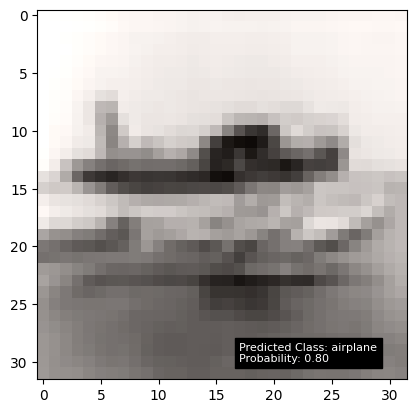

Print probabilities for each class:
airplane: 0.7978
automobile: 0.0437
bird: 0.0144
cat: 0.0011
deer: 0.0012
dog: 0.0001
frog: 0.0001
horse: 0.0002
ship: 0.1305
truck: 0.0109


In [22]:
inputs, classes = next(iter(test_dataloader))
inputs = inputs.to(device)
inputs = inputs[5:6]

outputs = model(inputs)

instance_inference(inputs[0].cpu(), outputs, class_names)